# Video Action Recognition with Transfer Learning

This notebook illustrates the application of transfer learning to video action recognition. We'll employ a pretrained model from TensorFlow Hub to classify videos, specifically utilizing the InceptionV3 I3D model.

## Key Objectives

1. **Load a Pretrained Model:** Obtain a pretrained video classifier from TensorFlow Hub.
2. **Feature Extraction:** Extract meaningful features from video data using the pretrained model.
3. **Classifier Training:** Train a classifier on new action categories, leveraging the extracted features.
4. **Performance Evaluation:** Assess the performance of the trained model on a video classification task.

## Import Required Libraries
We need TensorFlow Hub for loading pretrained video models, OpenCV for video processing, and imageio for creating video visualizations. Video processing requires special libraries to handle temporal sequences.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import HTML
import imageio

## Video Data Preparation
We create a mock video dataset with synthetic action sequences. Each video consists of 16 frames showing different motion patterns:
- Walking: horizontal movement
- Running: faster horizontal movement
- Jumping: vertical oscillation
- Sitting: stationary low position
- Standing: stationary vertical position

In real applications, you would load actual video files instead.

In [2]:
import numpy as np
import cv2

# Create mock video dataset with reordered classes
def create_mock_videos(num_videos=50, frames_per_video=16, video_size=(224, 224)):
    """Generate synthetic video clips for multiple action categories."""
    videos = []
    labels = []

    action_classes = ['jumping', 'sitting', 'walking', 'standing', 'running']

    for i in range(num_videos):
        frames = []
        class_idx = i % len(action_classes)
        action = action_classes[class_idx]

        for frame_idx in range(frames_per_video):
            frame = np.zeros((video_size[0], video_size[1], 3), dtype=np.uint8)

            if action == 'jumping':
                offset_y = int(video_size[0] // 2 + 50 * np.sin(frame_idx * 0.5))
                cv2.circle(frame, (video_size[1] // 2, offset_y), 25, (0, 0, 255), -1)
            elif action == 'sitting':
                cv2.rectangle(frame, (video_size[1] // 2 - 30, video_size[0] // 2),
                              (video_size[1] // 2 + 30, video_size[0] // 2 + 50), (255, 255, 0), -1)
            elif action == 'walking':
                offset = int(frame_idx * 10) % video_size[0]
                cv2.circle(frame, (offset, video_size[0] // 2), 20, (255, 0, 0), -1)
            elif action == 'standing':
                cv2.rectangle(frame, (video_size[1] // 2 - 20, video_size[0] // 2 - 50),
                              (video_size[1] // 2 + 20, video_size[0] // 2 + 50), (255, 0, 255), -1)
            else:  # running
                offset = int(frame_idx * 20) % video_size[0]
                cv2.circle(frame, (offset, video_size[0] // 2), 30, (0, 255, 0), -1)

            frames.append(frame)

        videos.append(np.array(frames))
        labels.append(class_idx)

    return np.array(videos), np.array(labels), action_classes

# Generate mock dataset
print("Creating mock video dataset...")
video_data, video_labels, action_classes = create_mock_videos()
print(f"Created {len(video_data)} videos")
print(f"Video shape: {video_data[0].shape}")
print(f"Action classes: {action_classes}")


Creating mock video dataset...
Created 50 videos
Video shape: (16, 224, 224, 3)
Action classes: ['jumping', 'sitting', 'walking', 'standing', 'running']


## Video Feature Extraction with I3D
Load the I3D (Inflated 3D ConvNet) model from TensorFlow Hub. I3D is pretrained on Kinetics-400 dataset and can extract spatio-temporal features from videos. We preprocess videos to the required format (224x224 frames, normalized pixel values) and extract features that capture both spatial and temporal information.

In [ ]:
# Load pretrained video model from TensorFlow Hub
print("Loading I3D model from TensorFlow Hub...")
i3d_model_url = "https://tfhub.dev/deepmind/i3d-kinetics-400/1"
i3d_model = hub.load(i3d_model_url)

# Get the model signatures
signatures = list(i3d_model.signatures.keys())
print(f"Available signatures: {signatures}")
infer = i3d_model.signatures['default']

# I3D expects videos in specific format
def preprocess_video(video_frames):
    """Preprocess video for I3D model"""
    # Resize frames to 224x224
    resized_frames = []
    for frame in video_frames:
        resized_frame = cv2.resize(frame, (224, 224))
        resized_frames.append(resized_frame)

    # Convert to float32 and normalize
    video_array = np.array(resized_frames)
    video_tensor = tf.convert_to_tensor(video_array, dtype=tf.float32)
    video_tensor = video_tensor / 255.0

    # Add batch dimension
    video_tensor = tf.expand_dims(video_tensor, 0)

    return video_tensor

# Extract features from videos using I3D
def extract_video_features(videos, model_fn):
    features = []

    for i, video in enumerate(videos):
        if i % 10 == 0:
            print(f"Processing video {i}/{len(videos)}")

        # Preprocess video
        processed_video = preprocess_video(video)

        # Extract features
        with tf.device('/CPU:0'):  # Use CPU to avoid memory issues
            output_dict = model_fn(processed_video)
            # Get logits (features before final classification)
            feature_vector = output_dict['default']

        features.append(feature_vector.numpy())

    return np.array(features).squeeze()

# Extract features
print("Extracting features using I3D...")
video_features = extract_video_features(video_data, infer)
print(f"Feature shape: {video_features.shape}")

Loading I3D model from TensorFlow Hub...
Available signatures: ['default']
Extracting features using I3D...
Processing video 0/50
Processing video 10/50
Processing video 20/50
Processing video 30/50
Processing video 40/50
Feature shape: (50, 400)


## Train Video Classifier
Using the extracted I3D features, we train a simple neural network classifier for our custom action recognition task. The classifier maps the 400-dimensional feature vectors from I3D to our 5 action classes. This transfer learning approach allows us to leverage the powerful feature extraction capabilities of I3D while adapting to our specific task.

In [ ]:
# Split data for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    video_features, video_labels, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a simple classifier for video classification
video_classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(400,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(5, activation='softmax')
])

video_classifier.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the classifier
print("Training video classifier...")
video_history = video_classifier.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=16,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training video classifier...
Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 730ms/step - accuracy: 0.2917 - loss: 1.4485 - val_accuracy: 1.0000 - val_loss: 0.4386
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9583 - loss: 0.5276 - val_accuracy: 1.0000 - val_loss: 0.1567
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.2411 - val_accuracy: 1.0000 - val_loss: 0.0569
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0971 - val_accuracy: 1.0000 - val_loss: 0.0207
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0672 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0213 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accura

## Video Classification Results
Evaluate the video classifier performance using confusion matrix and classification report. This helps identify which actions are correctly classified and which ones are commonly confused. Video classification is challenging due to the need to capture both spatial and temporal information.

Test Accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


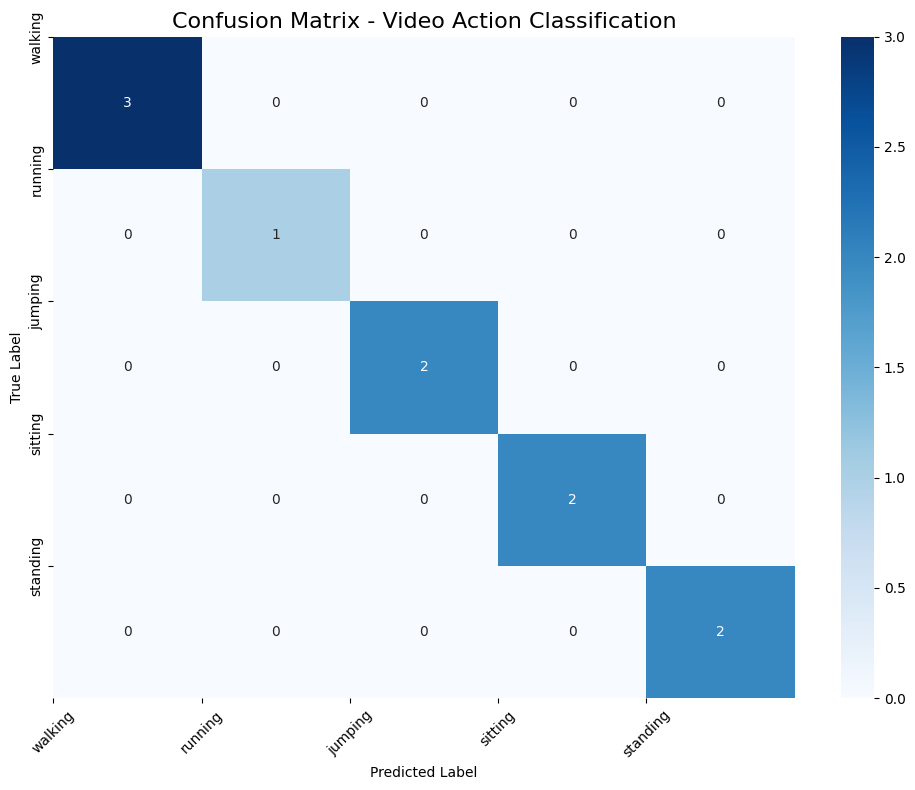


Classification Report:
              precision    recall  f1-score   support

     walking       1.00      1.00      1.00         3
     running       1.00      1.00      1.00         1
     jumping       1.00      1.00      1.00         2
     sitting       1.00      1.00      1.00         2
    standing       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [ ]:
# Evaluate and visualize results
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test set
test_loss, test_accuracy = video_classifier.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = video_classifier.predict(X_test_scaled)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Video Action Classification', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(len(action_classes)), action_classes, rotation=45)
plt.yticks(range(len(action_classes)), action_classes)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels, target_names=action_classes))

## Video Prediction Visualization
Visualize sample videos and their predictions to understand how the model performs on different action types. We display key frames from each video along with the true and predicted labels. This visualization helps debug classification errors and understand the model's behavior on the temporal data.


Video 0:
True class: walking
Predicted class: walking (confidence: 1.00)


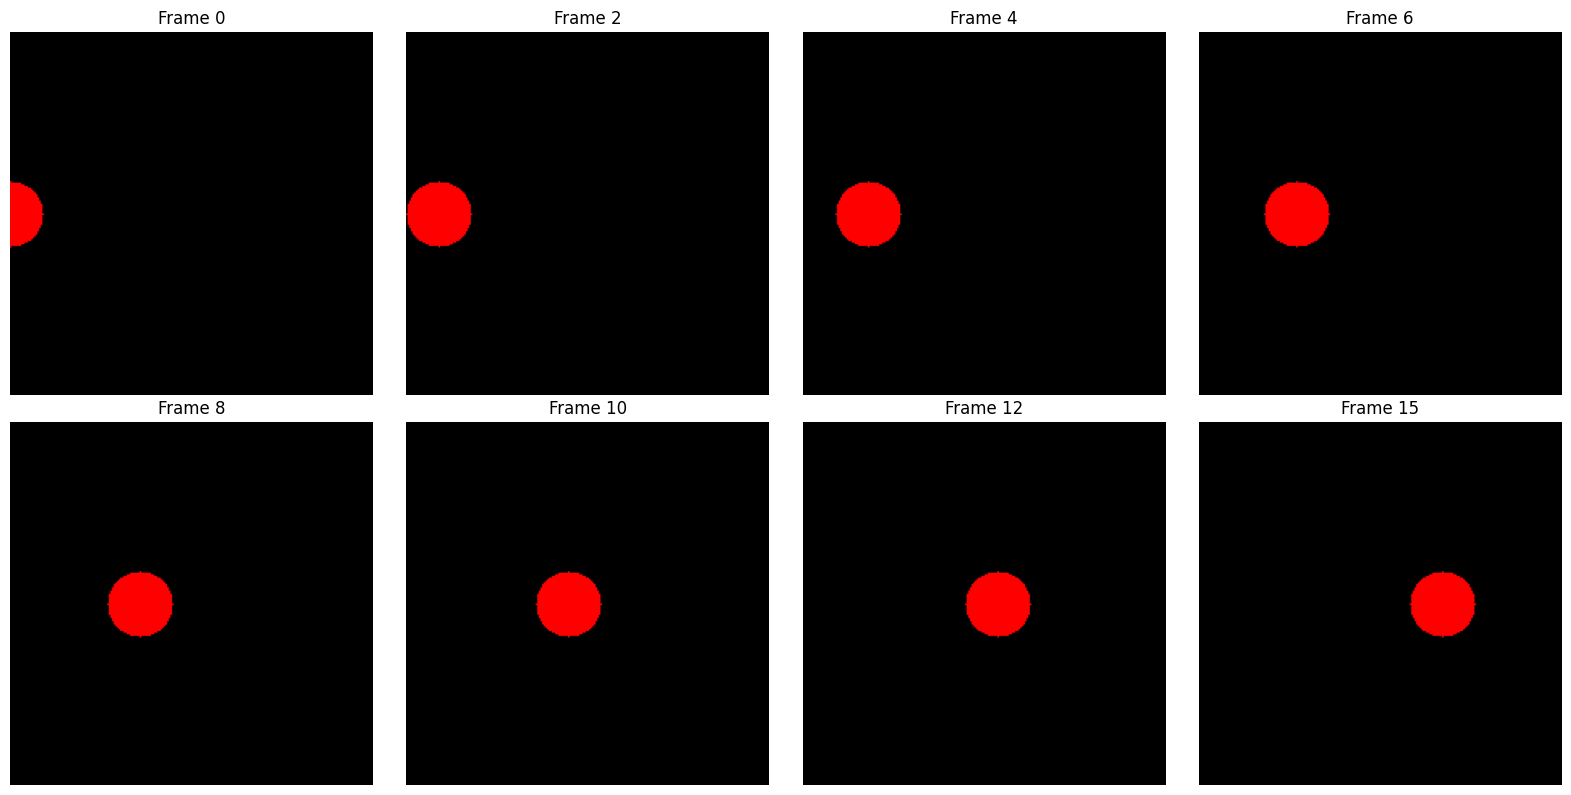


Video 10:
True class: walking
Predicted class: walking (confidence: 1.00)


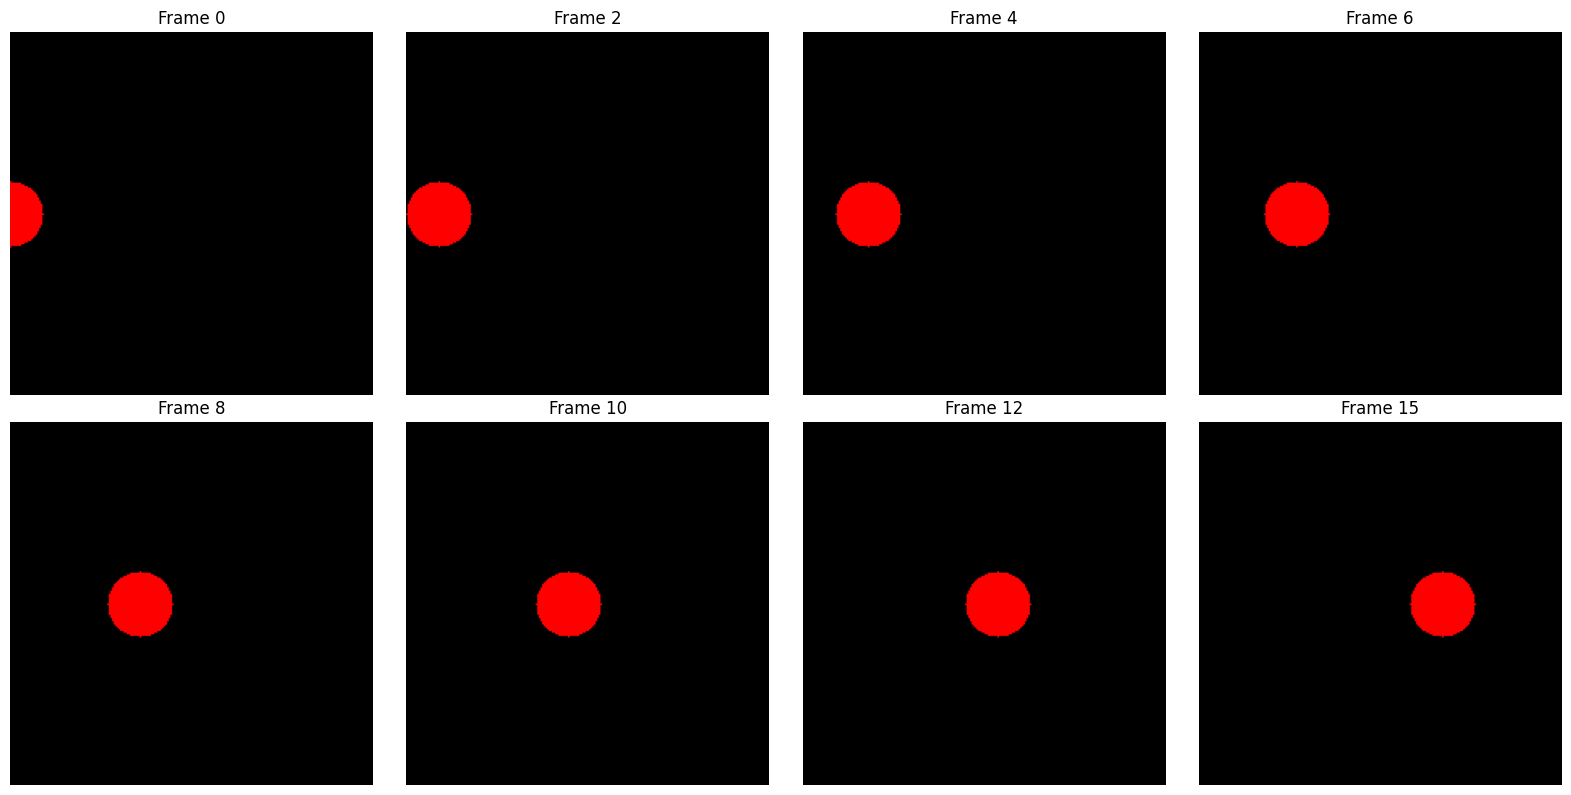


Video 20:
True class: walking
Predicted class: walking (confidence: 1.00)


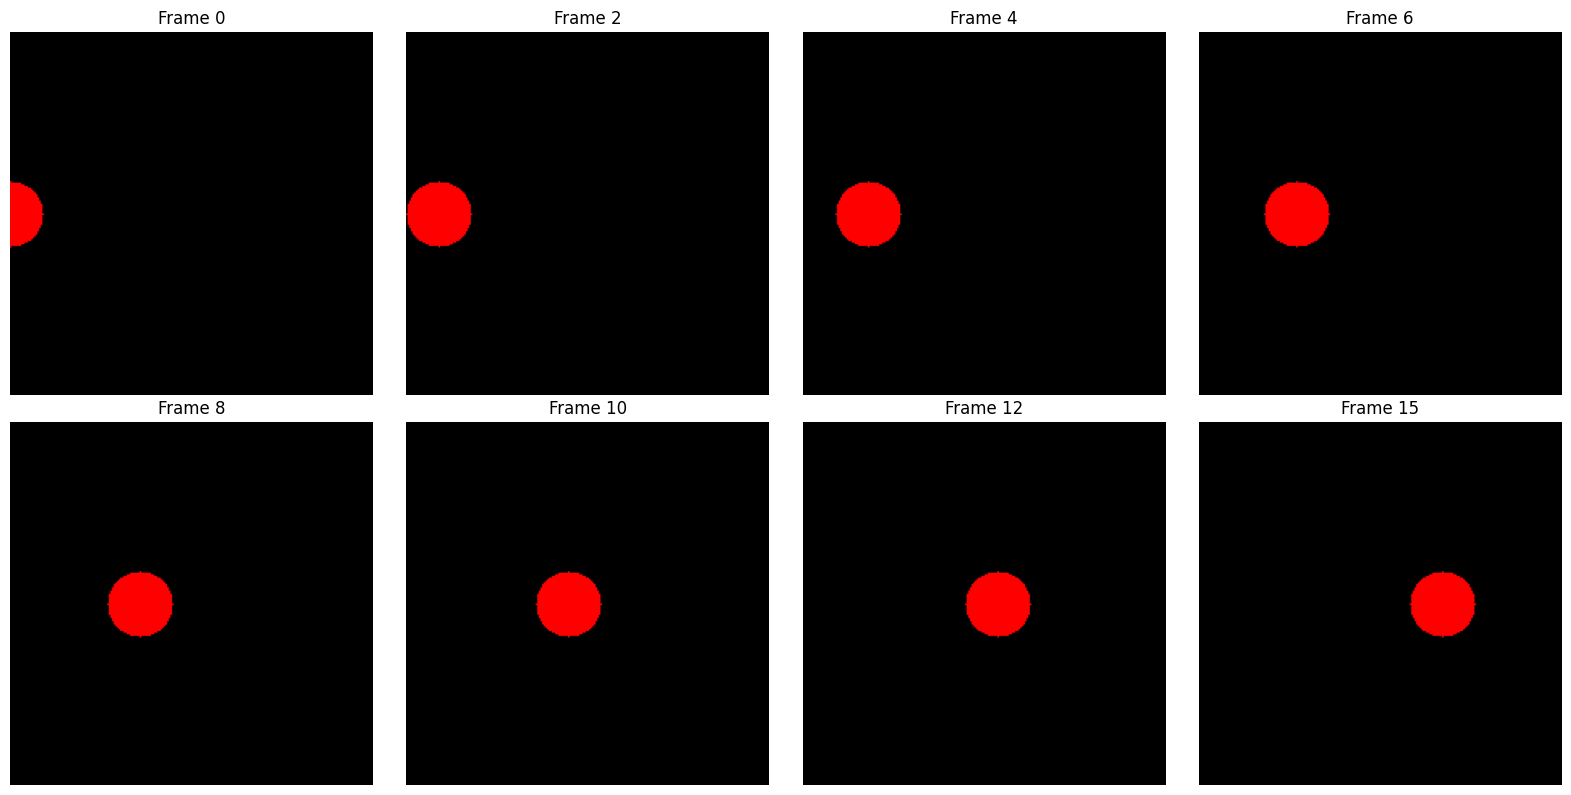


Video 30:
True class: walking
Predicted class: walking (confidence: 1.00)


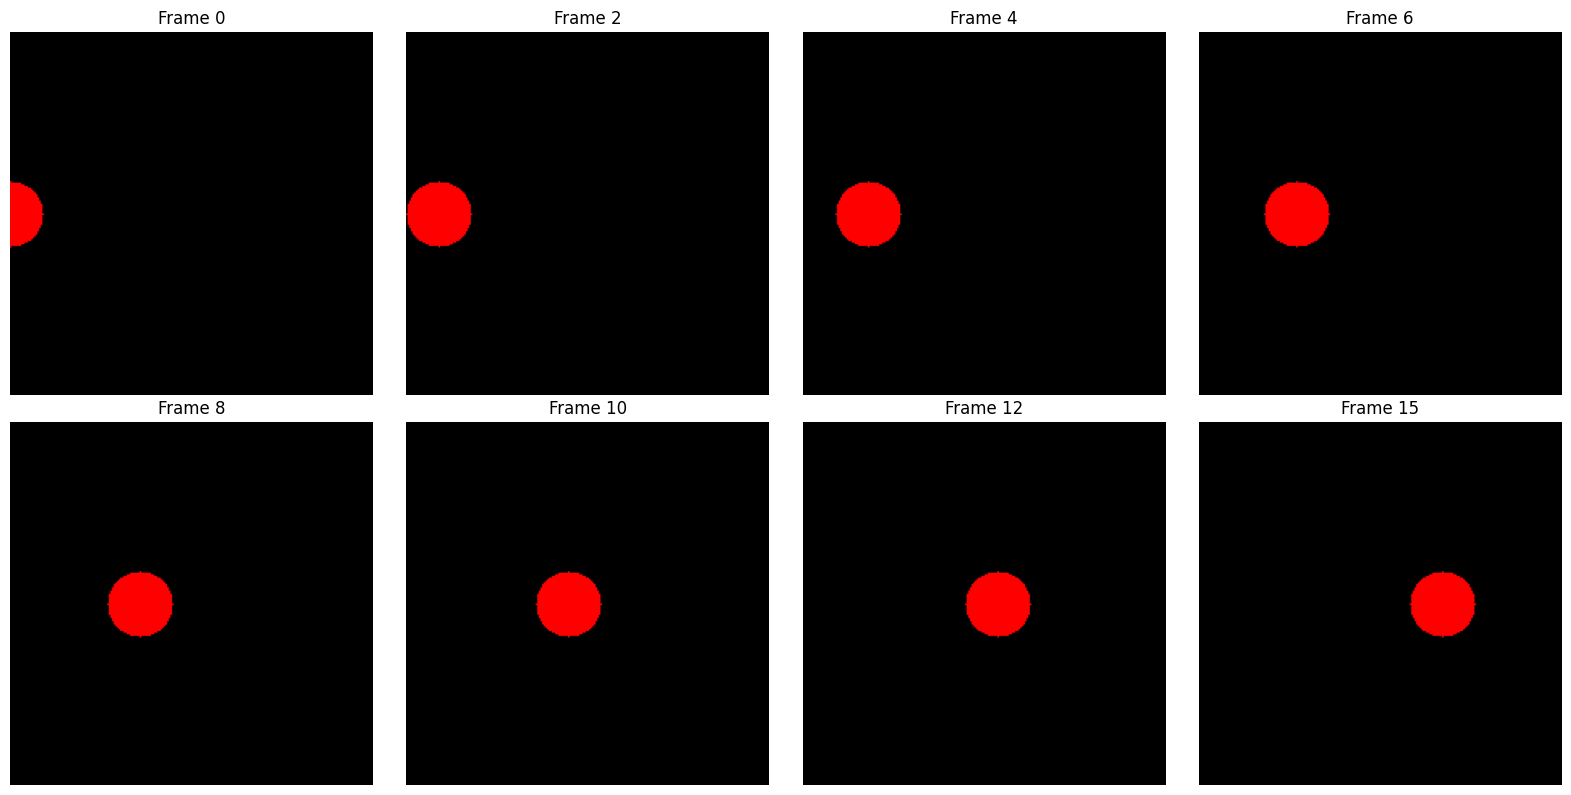


Video 40:
True class: walking
Predicted class: walking (confidence: 1.00)


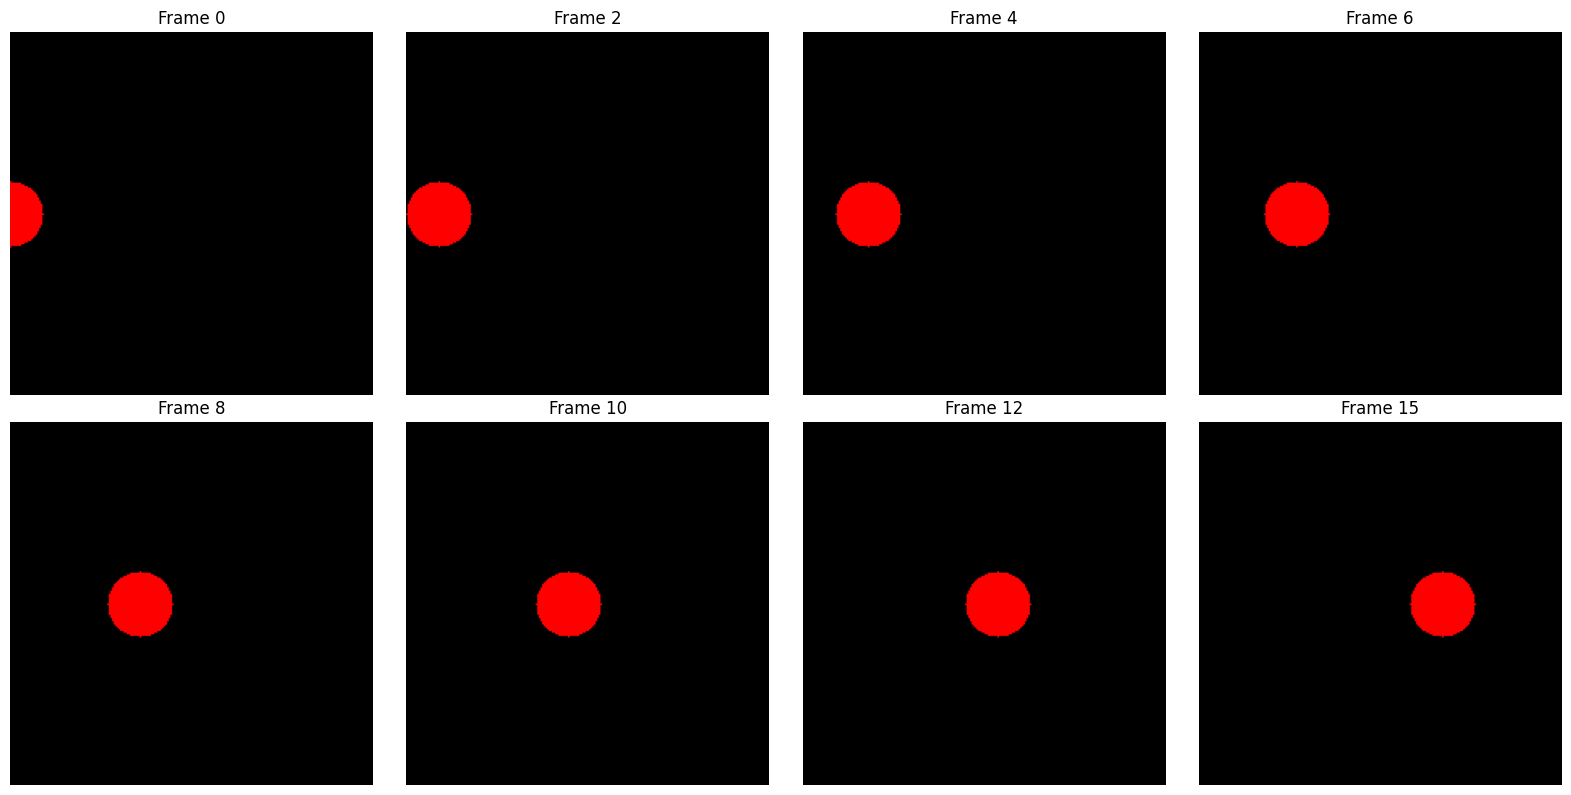

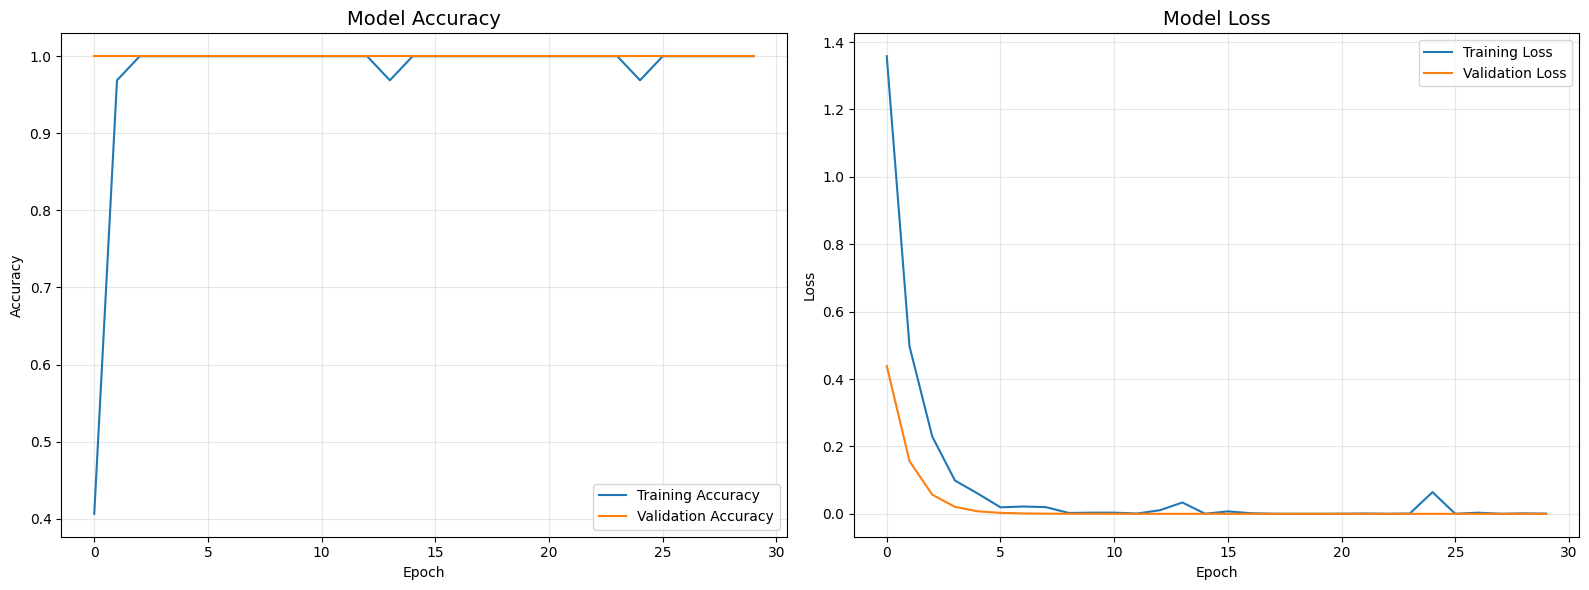

In [ ]:
# Visualize video samples and predictions
def visualize_video_grid(video, frames_to_show=8):
    """Create a grid visualization of video frames"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    frame_indices = np.linspace(0, len(video)-1, frames_to_show, dtype=int)

    for idx, frame_idx in enumerate(frame_indices):
        axes[idx].imshow(video[frame_idx])
        axes[idx].axis('off')
        axes[idx].set_title(f'Frame {frame_idx}')

    plt.tight_layout()
    plt.show()

# Show predictions for sample videos
sample_indices = [0, 10, 20, 30, 40]

for idx in sample_indices:
    video = video_data[idx]
    true_label = action_classes[video_labels[idx]]

    # Make prediction
    feature = video_features[idx].reshape(1, -1)
    feature_scaled = scaler.transform(feature)
    prediction = video_classifier.predict(feature_scaled, verbose=0)
    predicted_label = action_classes[np.argmax(prediction)]
    confidence = prediction[0][np.argmax(prediction)]

    print(f"\nVideo {idx}:")
    print(f"True class: {true_label}")
    print(f"Predicted class: {predicted_label} (confidence: {confidence:.2f})")

    # Visualize the video
    visualize_video_grid(video)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
ax1.plot(video_history.history['accuracy'], label='Training Accuracy')
ax1.plot(video_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(video_history.history['loss'], label='Training Loss')
ax2.plot(video_history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()